In [12]:
%%capture
import joblib
%run "EDA.ipynb"

### MODELES


### Random forest pour la prédiction du rendement agricole (yield)

In [13]:
df_clean.head()

,fnid,country,country_code,admin_1,admin_2,product,season_name,planting_year,planting_month,harvest_year,harvest_month,crop_production_system,qc_flag,area,production,yield,season_group
36,AO2008A101,Angola,AO,Bengo,none,Maize,Main,1996,10,1997,4,All (PS),0,11000.0,6710.0,0.610000,Main
37,AO2008A101,Angola,AO,Bengo,none,Maize,Main,1997,10,1998,4,All (PS),0,14000.0,9800.0,0.700000,Main
38,AO2008A101,Angola,AO,Bengo,none,Maize,Main,1998,10,1999,4,All (PS),0,9176.0,8258.0,0.899956,Main
39,AO2008A101,Angola,AO,Bengo,none,Maize,Main,1999,10,2000,4,All (PS),0,10002.0,12002.0,1.199960,Main
40,AO2008A101,Angola,AO,Bengo,none,Maize,Main,2000,10,2001,4,All (PS),0,6368.0,3821.0,0.600031,Main


In [14]:
# Création de la colonne simplifiée par défaut
df_clean['system_simplified'] = 'other'

# Conversion en minuscules pour faciliter la recherche
sys_lower = df_clean['crop_production_system'].str.lower()

# 1. Irrigation
# Regroupe : irrigated, riverine, surface water, dam irrigation, plaine/bas-fond
mask_irrigated = sys_lower.str.contains('irrigated|water|dam|riverine', na=False)
df_clean.loc[mask_irrigated, 'system_simplified'] = 'irrigated'

# 2. Pluvial (Rainfed)
# Regroupe : Rainfed (PS), dieri, recessional (parastatal ou simple)
mask_rainfed = sys_lower.str.contains('rainfed|dieri|recessional', na=False)
df_clean.loc[mask_rainfed, 'system_simplified'] = 'rainfed'

# 3. Commercial / Grande échelle
# Regroupe : Commercial (PS), LSCF (Large Scale), large_scale
mask_commercial = sys_lower.str.contains('commercial|large_scale|lscf', na=False)
df_clean.loc[mask_commercial, 'system_simplified'] = 'commercial'

# 4. Traditionnel / Petite échelle
# Regroupe : agro_pastoral, Communal, Small_and_medium, SSCF, A1, A2, OR (Old Resettlement)
mask_traditional = sys_lower.str.contains('traditional|communal|small|pastoral|sscf|a1|a2|or \(ps\)', na=False)
df_clean.loc[mask_traditional, 'system_simplified'] = 'traditional_small_scale'

# 5. Inconnu / Général
# Regroupe : All (PS), none
mask_unknown = sys_lower.str.contains('all|none', na=False)
df_clean.loc[mask_unknown, 'system_simplified'] = 'general_unknown'

# Vérification 
print(df_clean['system_simplified'].value_counts())

system_simplified
general_unknown            14031
irrigated                   1195
rainfed                     1160
traditional_small_scale      342
commercial                   145
Name: count, dtype: int64



Données prêtes. Train shape: (13498, 38), Test shape: (3375, 38)

Lancement de l'optimisation (Grid Search)... Veuillez patienter.
Fitting 3 folds for each of 24 candidates, totalling 72 fits

MEILLEURS PARAMÈTRES : {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

--- PERFORMANCE SUR LE TEST SET ---
MAE (Erreur moyenne)  : 0.4261 tonnes/ha
RMSE (Erreur quadratique): 0.6408 tonnes/ha
R² (Précision globale): 0.4312


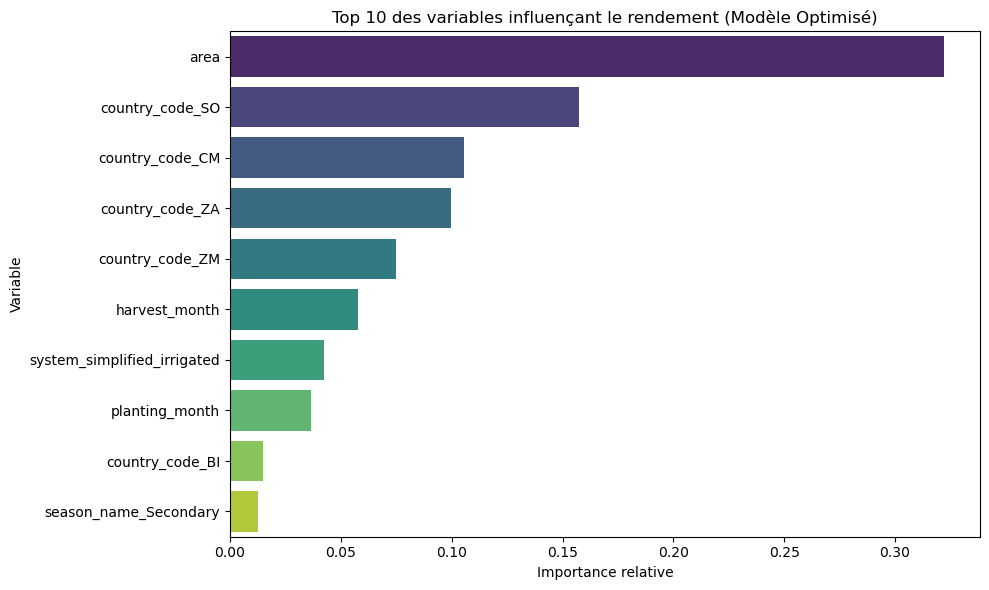

In [15]:
# =============================================================================
# 2. NETTOYAGE & STANDARDISATION
# =============================================================================
# On crée une colonne simplifiée pour regrouper les systèmes de production
df_clean['system_simplified'] = 'other'
sys_lower = df_clean['crop_production_system'].str.lower()

# Règles de standardisation
mask_irrigated = sys_lower.str.contains('irrigated|water|dam|riverine', na=False)
df_clean.loc[mask_irrigated, 'system_simplified'] = 'irrigated'

mask_rainfed = sys_lower.str.contains('rainfed|dieri|recessional', na=False)
df_clean.loc[mask_rainfed, 'system_simplified'] = 'rainfed'

mask_commercial = sys_lower.str.contains('commercial|mechanized|large_scale|lscf', na=False)
df_clean.loc[mask_commercial, 'system_simplified'] = 'commercial_mechanized'

mask_traditional = sys_lower.str.contains('traditional|communal|small|pastoral|sscf|a1|a2', na=False)
df_clean.loc[mask_traditional, 'system_simplified'] = 'traditional_small_scale'

mask_unknown = sys_lower.str.contains('all|none|or \(ps\)', na=False)
df_clean.loc[mask_unknown, 'system_simplified'] = 'general_unknown'




# =============================================================================
# 3. PRÉPARATION DES FEATURES (X) ET TARGET (y)
# =============================================================================
# Sélection des colonnes utiles
features_cols = ['country_code', 'season_name', 'planting_month', 
                 'harvest_month', 'area', 'system_simplified']

X = df_clean[features_cols]
y = df_clean['yield']

# Encodage One-Hot (Transforme le texte en colonnes 0/1)
X = pd.get_dummies(X, columns=['country_code', 'season_name', 'system_simplified'], drop_first=True)

# Division : 80% Entraînement, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDonnées prêtes. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# =============================================================================
# 4. OPTIMISATION DU MODÈLE (GRID SEARCH)
# =============================================================================
# Définition des paramètres à tester
# Note : J'ai mis une grille raisonnable pour ne pas que ça tourne 2 heures.
param_grid = {
    'n_estimators': [100, 200],      # Nombre d'arbres
    'max_depth': [None, 15, 30],     # Profondeur max
    'min_samples_split': [2, 5],     # Minimum pour diviser
    'min_samples_leaf': [1, 2]       # Minimum dans une feuille
}

# Initialisation du Random Forest
rf = RandomForestRegressor(random_state=42)

# Configuration de la recherche (3 validations croisées pour aller plus vite)
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1,  # Utilise tous les cœurs du processeur
                           verbose=1, 
                           scoring='r2')

print("\nLancement de l'optimisation (Grid Search)... Veuillez patienter.")
grid_search.fit(X_train, y_train)

# =============================================================================
# 5. ÉVALUATION ET RÉSULTATS
# =============================================================================
print("\n" + "="*50)
print(f"MEILLEURS PARAMÈTRES : {grid_search.best_params_}")
print("="*50)

# On récupère le meilleur modèle
best_model = grid_search.best_estimator_

# Prédictions sur le jeu de test (qu'il n'a jamais vu)
y_pred = best_model.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- PERFORMANCE SUR LE TEST SET ---")
print(f"MAE (Erreur moyenne)  : {mae:.4f} tonnes/ha")
print(f"RMSE (Erreur quadratique): {rmse:.4f} tonnes/ha")
print(f"R² (Précision globale): {r2:.4f}")

# =============================================================================
# 6. VISUALISATION DES FACTEURS IMPORTANTS
# =============================================================================
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Top 10 des variables influençant le rendement (Modèle Optimisé)')
plt.xlabel('Importance relative')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [16]:
# Sauvegarde du modèle Random Forest optimisé
model_path = '../ml_models_pkg/random_forest_model.pkl'
joblib.dump(best_model, model_path)
print(f"Modèle Random Forest sauvegardé à : {model_path}")

# Sauvegarde aussi la configuration des features (noms des colonnes)
# Cela sera nécessaire pour faire des prédictions futures
features_path = '../ml_models_pkg/feature_names.pkl'
joblib.dump(X.columns.tolist(), features_path)
print(f"Noms des features sauvegardés à : {features_path}")

Modèle Random Forest sauvegardé à : ../ml_models_pkg/random_forest_model.pkl
Noms des features sauvegardés à : ../ml_models_pkg/feature_names.pkl
